<a href="https://colab.research.google.com/github/MainaLD/21_Segmentation_lesions_pulmonaires/blob/main/U-NET_Segmentation_lesions_pulmonaires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation des lésions pulmonaires




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm


## Partie 1 : Base de données

La DataSet se trouve sur : https://drive.google.com/file/d/1TVQ5a-IOdn95eAAT8QLVA45s8WBAW1re/view?usp=sharing

Par la suite, il faut développer les étapes suivantes :

* Charger les images. 
* Penser à redimensionner les images selon le modèle souhaité. 
* Splitter les données en données d’apprentissage, validation et test. 
* Visualiser les images de CT et sa vérité terrain (segmentation manuelle). 
* Appliquer la data augmentation.

In [ ]:
# Download data
#!unzip /content/CT_Scan_Lesion_Segmentation.zip -d /content/Untitled Folder

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/21_Segmentation_U-NET/CT_Scan_Lesion_Segmentation.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/21_Segmentation_U-NET/Data")

In [10]:
ls /content/drive/MyDrive/21_Segmentation_U-NET/Data

frames/  masks/  tab_img_save.npy  tab_mask_save.npy  Unet_weights.h5


In [3]:
os.chdir("/content/drive/MyDrive/21_Segmentation_U-NET/Data")
path = os.getcwd()
labels = os.listdir(path) 
print(labels) 

['frames', 'masks', 'Unet_weights.h5', 'tab_img_save.npy', 'tab_mask_save.npy']


In [12]:
ls

frames/  masks/  tab_img_save.npy  tab_mask_save.npy  Unet_weights.h5


In [4]:
dir_frames=path+"/frames/"
print(dir_frames)
dir_mask=path+"/masks/"
print(dir_mask)

/content/drive/MyDrive/21_Segmentation_U-NET/Data/frames/
/content/drive/MyDrive/21_Segmentation_U-NET/Data/masks/


In [17]:
width=224
height=224
channels=3

tab_img=[]
tab_mask=[]

for n, i in tqdm(enumerate(os.listdir(dir_frames)), total=len(os.listdir(dir_frames))):
    tab_img.append(cv2.resize(cv2.imread(dir_frames+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)
    img_mask_result[:,:,0][img_mask==255]=1.
    tab_mask.append(img_mask_result)

100%|██████████| 2729/2729 [11:11<00:00,  4.06it/s]


In [19]:
tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)
tab_img.shape, tab_mask.shape

((2729, 224, 224, 3), (2729, 224, 224, 1))

In [6]:
# Sauvegarder les np.array dans un fichier numpy *.npy
np.save('tab_img_save.npy', tab_img)
np.save('tab_mask_save.npy', tab_mask)

In [7]:
# Chargement des données 
tab_img = np.load('tab_img_save.npy')
tab_mask = np.load('tab_mask_save.npy')
tab_img.shape, tab_mask.shape

((2729, 224, 224, 3), (2729, 224, 224, 1))



*   **Visualisation des images**



In [22]:
nb = []
for i in range(25):
    nbr = np.random.randint(0, 2729, [1])
    nb.append(nbr)
nb

[array([1574]),
 array([83]),
 array([994]),
 array([1674]),
 array([1592]),
 array([2399]),
 array([1671]),
 array([530]),
 array([1013]),
 array([1314]),
 array([2512]),
 array([724]),
 array([726]),
 array([2482]),
 array([9]),
 array([37]),
 array([2365]),
 array([2694]),
 array([1080]),
 array([2068]),
 array([441]),
 array([246]),
 array([1785]),
 array([38]),
 array([1997])]

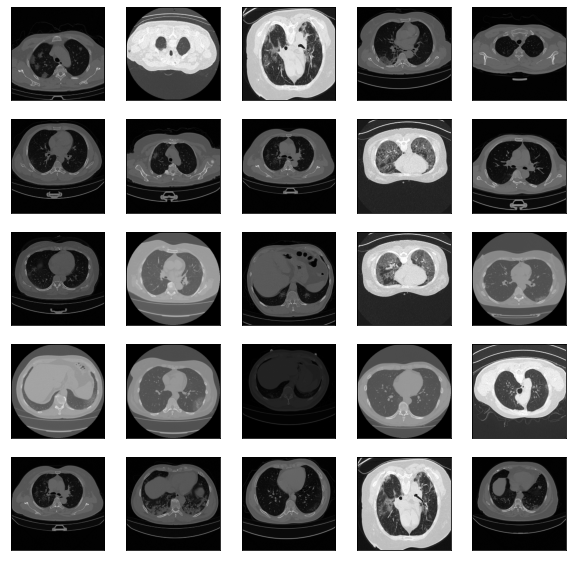

In [23]:
#import tensorflow as tf
#from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    nbr = np.random.randint(0, 2729, [1])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tab_img[nbr[0]])
    # [nbr[0] = chiffre aléatoire du l'image, : pr width, : pr height, pr les couche, ici 1 couche donc 0)
    #plt.imshow(tab_mask[nbr[0],:,:,0])
plt.show()


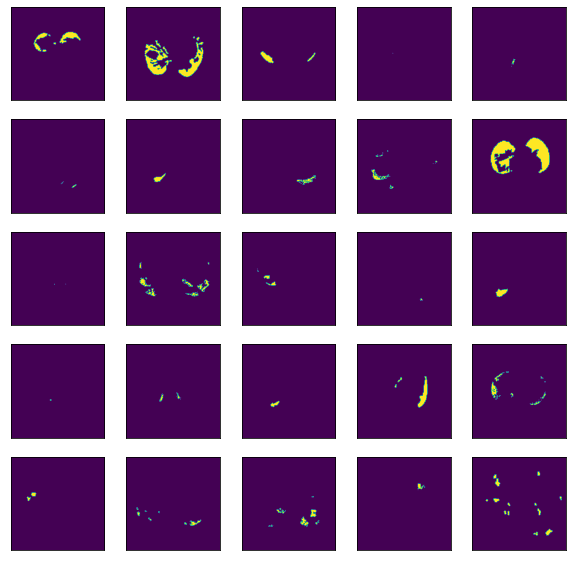

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    nbr = np.random.randint(0, 1524, [1])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # nbr[0] = chiffre aléatoire, 
    plt.imshow(tab_mask[nbr[0],:,:,0])
plt.show()



*   **séparation du jeu train/valid et test**



In [8]:
# Séparation du jeu de donnée
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(tab_img, tab_mask, test_size = 0.2, random_state = 0)
img_train.shape, img_test.shape, mask_train.shape, mask_test.shape

((2183, 224, 224, 3),
 (546, 224, 224, 3),
 (2183, 224, 224, 1),
 (546, 224, 224, 1))

In [9]:
tab_img = []
tab_mask = []



*   **Data augmentation**



In [10]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
# je prépare le model qui va faire le data augmentation
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
# configuration pour mask, !!! appliquer les mêmes paramètres que pour image
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

In [ ]:
print(image_datagen, mask_datagen)

<keras.preprocessing.image.ImageDataGenerator object at 0x7fd170c753d0> <keras.preprocessing.image.ImageDataGenerator object at 0x7fd1619dd310>


In [11]:
seed = 42
# .fit = entrainer data augmentation
image_datagen.fit(img_train[:int(img_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(mask_train[:int(mask_train.shape[0]*0.9)], augment=True, seed=seed)

In [12]:
BATCH_SIZE = 32
# .flow = appliquer data augmentation 
# tab_img.shape[0] = nb image dans tab_img
# tab_img[:int(tab_img.shape[0]*0.9)] = je prends les images de 0.9 du total
x=image_datagen.flow(img_train[:int(img_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(mask_train[:int(mask_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


In [ ]:
print(x,y)

<keras.preprocessing.image.NumpyArrayIterator object at 0x7fd0f8db1c10> <keras.preprocessing.image.NumpyArrayIterator object at 0x7fd0f911f890>


In [13]:
# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

In [ ]:
print(image_datagen_val,mask_datagen_val)

<keras.preprocessing.image.ImageDataGenerator object at 0x7fd0f8dbfe50> <keras.preprocessing.image.ImageDataGenerator object at 0x7fd0f8dbfa90>


In [14]:
image_datagen_val.fit(img_train[int(img_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(mask_train[int(mask_train.shape[0]*0.9):], augment=True, seed=seed)


In [15]:
x_val=image_datagen_val.flow(img_train[int(img_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(mask_train[int(mask_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


In [ ]:
print(x_val,y_val)

<keras.preprocessing.image.NumpyArrayIterator object at 0x7fd0f8d63890> <keras.preprocessing.image.NumpyArrayIterator object at 0x7fd0f8d5af10>


In [16]:
#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [ ]:
print(train_generator,val_generator)

<zip object at 0x7fd0f8d6a9b0> <zip object at 0x7fd0f8d6aaf0>


## Partie 2 : Transfer Learning

*   Cette deuxième partie est réservée pour préparer le modèle de segmentation et d’appliquer un Transfer Learning sur votre architecture.

*   Calculer le F1-Score sur la base de test.

In [17]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.6 MB/s 


In [18]:
from segmentation_models import Unet


Segmentation Models: using `keras` framework.


In [19]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [20]:
# congig Unet, ici ce sera 224x224, attention ici sigmoide	= 1 classe
model = sm.Unet('resnet34', encoder_weights='imagenet', classes=1, input_shape=(224,224, 3), activation='sigmoid')
#model.summary()

85532672/85521592 [==============================] - 6s 0us/step


In [21]:
import tensorflow as tf
m = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)
model.compile('Adam', loss="binary_crossentropy", metrics=[m])

In [22]:
# j'enregistre le dernier modèle
results = model.fit_generator(train_generator, 
                              validation_data=val_generator, 
                              validation_steps=250, 
                              steps_per_epoch=500,
                              epochs=5)
model.save_weights('Unet_weights.hdf5')
model.save("Unet.h5")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
500/500 [==============================] - 359s 671ms/step - loss: 0.0652 - binary_io_u: 0.6573 - val_loss: 0.0849 - val_binary_io_u: 0.4927
Epoch 2/5
500/500 [==============================] - 332s 666ms/step - loss: 0.0165 - binary_io_u: 0.8096 - val_loss: 0.0231 - val_binary_io_u: 0.7807
Epoch 3/5
500/500 [==============================] - 313s 626ms/step - loss: 0.0145 - binary_io_u: 0.8233 - val_loss: 0.0130 - val_binary_io_u: 0.8479
Epoch 4/5
500/500 [==============================] - 335s 671ms/step - loss: 0.0134 - binary_io_u: 0.8327 - val_loss: 0.0146 - val_binary_io_u: 0.8308
Epoch 5/5
500/500 [==============================] - 348s 697ms/step - loss: 0.0140 - binary_io_u: 0.8276 - val_loss: 0.0171 - val_binary_io_u: 0.7871


*   **Évaluer le modèle**

In [24]:
import matplotlib.pyplot as plt

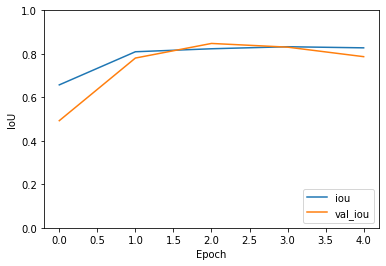

In [26]:
plt.plot(results.history['binary_io_u'], label='iou')
plt.plot(results.history['val_binary_io_u'], label = 'val_iou')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.ylim([0, 1])
plt.legend(loc='lower right')


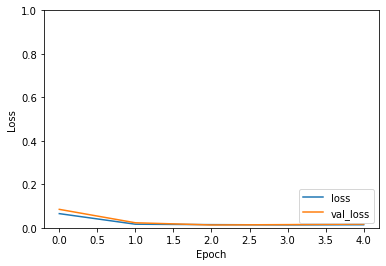

In [27]:
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [30]:
test_loss, test_bIoU = model.evaluate(img_test, mask_test, verbose=2)
print('test_loss = ', test_loss, ' //  test_bIoU =', test_bIoU)

18/18 - 3s - loss: 0.0162 - binary_io_u: 0.7884 - 3s/epoch - 186ms/step
test_loss =  0.016200926154851913  //  test_bIoU = 0.7884363532066345




*   **Prédiction avec les poids et le modèle sauvé**



In [34]:
modelW = sm.Unet('resnet34', encoder_weights='imagenet', classes=1, input_shape=(224,224, 3), activation='sigmoid')
modelW.load_weights('Unet_weights.hdf5')
y_predW = modelW.predict(img_test)

In [35]:
from keras.models import load_model
modelH5 = load_model("Unet.h5")
y_predH5 = modelH5.predict(img_test)

In [36]:
# Résultat sur le jeu test VS poids
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('\nMatrice de confusion : \n', confusion_matrix(mask_test, y_predW))
print('\nReport : \n', classification_report(mask_test, y_predW))

ValueError: ignored

In [ ]:
# Résultat sur le jeu test VS model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('\nMatrice de confusion : \n', confusion_matrix(mask_test, y_predH5))
print('\nReport : \n', classification_report(mask_test, y_predH5))

In [41]:
print(classification_report(mask_test, y_predH5))

ValueError: ignored

In [39]:
import sklearn.metrics

sklearn.metrics.f1_score(mask_test, y_predW)

ValueError: ignored